In [ ]:
from IPython.display import clear_output
!git clone https://github.com/matterport/Mask_RCNN.git # load Mask R-CNN code implementation
!git clone https://github.com/Anushaaelango/brain-tumor.git # load new data set and annotations 
!pip install pycocotools

!rm -rf brain-tumor/.git/
!rm -rf Mask_RCNN/.git/

clear_output()

In [ ]:
#  Upgrade keras/tensorflow jika dibutuhkan
!pip install keras==2.1.5

!pip install tensorflow==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Upgrade numpy jika dibutuhkan
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Upgrade h5py jika dibutuhkan
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 2.10.0
Uninstalling h5py-2.10.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-2.10.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-2.10.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)


In [ ]:
import os 
import sys
from tqdm import tqdm
import cv2
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random
import keras.engine.topology as KE
from keras.layers import Layer
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Root directory of the project
ROOT_DIR = os.path.abspath('Mask_RCNN/')
# Import Mask RCNN
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white'

clear_output()

In [ ]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') # directory to save logs and trained model
# ANNOTATIONS_DIR = 'brain-tumor/data/new/annotations/' # directory with annotations for train/val sets
DATASET_DIR = 'brain-tumor/data_cleaned/' # directory with image data
DEFAULT_LOGS_DIR = 'logs' 

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
class TumorConfig(Config):
    """Configuration for training on the brain tumor dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [ ]:
class BrainScanDataset(utils.Dataset):

    def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the FarmCow dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")

        # Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_'+subset+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [ ]:
# Training dataset.
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=5,
    layers='heads'
)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/tumor_detector20220619T1016/mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe.

  2/100 [..............................] - ETA: 25:54 - loss: 6.7945 - rpn_class_loss: 0.3114 - rpn_bbox_loss: 4.4441 - mrcnn_class_loss: 1.3018 - mrcnn_bbox_loss: 0.2744 - mrcnn_mask_loss: 0.4629    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  4/100 [>.............................] - ETA: 13:07 - loss: 4.5965 - rpn_class_loss: 0.1588 - rpn_bbox_loss: 2.7197 - mrcnn_class_loss: 0.7001 - mrcnn_bbox_loss: 0.5272 - mrcnn_mask_loss: 0.4907

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  6/100 [>.............................] - ETA: 8:50 - loss: 5.0883 - rpn_class_loss: 0.1337 - rpn_bbox_loss: 3.5566 - mrcnn_class_loss: 0.4730 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.4466 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  8/100 [=>............................] - ETA: 6:41 - loss: 4.3063 - rpn_class_loss: 0.1060 - rpn_bbox_loss: 3.0167 - mrcnn_class_loss: 0.3554 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4180

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  9/100 [=>............................] - ETA: 5:58 - loss: 3.9768 - rpn_class_loss: 0.0962 - rpn_bbox_loss: 2.6873 - mrcnn_class_loss: 0.3169 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.4759

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 4:55 - loss: 3.6521 - rpn_class_loss: 0.1050 - rpn_bbox_loss: 2.2344 - mrcnn_class_loss: 0.2930 - mrcnn_bbox_loss: 0.5168 - mrcnn_mask_loss: 0.5029

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 13/100 [==>...........................] - ETA: 4:11 - loss: 3.4587 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 1.9792 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.5873 - mrcnn_mask_loss: 0.5375

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 15/100 [===>..........................] - ETA: 3:38 - loss: 3.2402 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 1.7468 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.6203 - mrcnn_mask_loss: 0.5588

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 17/100 [====>.........................] - ETA: 3:13 - loss: 3.0677 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.5964 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.6077 - mrcnn_mask_loss: 0.5586

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 19/100 [====>.........................] - ETA: 2:53 - loss: 2.9937 - rpn_class_loss: 0.0907 - rpn_bbox_loss: 1.5052 - mrcnn_class_loss: 0.2138 - mrcnn_bbox_loss: 0.6169 - mrcnn_mask_loss: 0.5671

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 21/100 [=====>........................] - ETA: 2:37 - loss: 2.9044 - rpn_class_loss: 0.0834 - rpn_bbox_loss: 1.4013 - mrcnn_class_loss: 0.1988 - mrcnn_bbox_loss: 0.6403 - mrcnn_mask_loss: 0.5806

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 22/100 [=====>........................] - ETA: 2:30 - loss: 2.8468 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.3487 - mrcnn_class_loss: 0.1900 - mrcnn_bbox_loss: 0.6452 - mrcnn_mask_loss: 0.5827

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 2:17 - loss: 2.7597 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.2669 - mrcnn_class_loss: 0.1833 - mrcnn_bbox_loss: 0.6518 - mrcnn_mask_loss: 0.5835

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 26/100 [======>.......................] - ETA: 2:06 - loss: 2.6972 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.1993 - mrcnn_class_loss: 0.1723 - mrcnn_bbox_loss: 0.6792 - mrcnn_mask_loss: 0.5774

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 28/100 [=======>......................] - ETA: 1:57 - loss: 2.6515 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.1484 - mrcnn_class_loss: 0.1800 - mrcnn_bbox_loss: 0.6775 - mrcnn_mask_loss: 0.5785

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 29/100 [=======>......................] - ETA: 1:52 - loss: 2.6173 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.1203 - mrcnn_class_loss: 0.1759 - mrcnn_bbox_loss: 0.6738 - mrcnn_mask_loss: 0.5786

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:45 - loss: 2.5780 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.0835 - mrcnn_class_loss: 0.1752 - mrcnn_bbox_loss: 0.6806 - mrcnn_mask_loss: 0.5744

ERROR:root:Error processing image {'id': '49.jpg', 'source': 'tumor', 'path': 'brain-tumor/data_cleaned/train/49.jpg', 'width': 256, 'height': 256, 'polygons': [{'name': 'polygon', 'all_points_x': [53, 50, 54, 62, 71, 75, 75, 71, 62, 56], 'all_points_y': [175, 184, 196, 203, 200, 192, 182, 170, 167, 168]}, {'name': 'polygon', 'all_points_x': [104, 120, 131, 156, 158, 155, 148, 134, 102, 86, 71, 72, 81, 92], 'all_points_y': [177, 174, 185, 203, 220, 239, 251, 256, 255, 248, 234, 220, 200, 186]}, {'name': 'polygon', 'all_points_x': [102, 98, 90, 84, 78, 75, 81, 96], 'all_points_y': [144, 133, 130, 132, 136, 142, 146, 151]}]}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-8-3d2b7a3b6e68>", line 69, in load_mask
    mask[rr, cc, i] = 1
IndexError: 

 32/100 [========>.....................] - ETA: 1:41 - loss: 2.5352 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.0534 - mrcnn_class_loss: 0.1742 - mrcnn_bbox_loss: 0.6728 - mrcnn_mask_loss: 0.5725

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:35 - loss: 2.5133 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 1.0292 - mrcnn_class_loss: 0.1688 - mrcnn_bbox_loss: 0.6770 - mrcnn_mask_loss: 0.5792

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 36/100 [=========>....................] - ETA: 1:29 - loss: 2.4711 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 0.9986 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.6809 - mrcnn_mask_loss: 0.5709

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 37/100 [==========>...................] - ETA: 1:26 - loss: 2.4587 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 0.9898 - mrcnn_class_loss: 0.1621 - mrcnn_bbox_loss: 0.6782 - mrcnn_mask_loss: 0.5713

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:20 - loss: 2.4516 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.9791 - mrcnn_class_loss: 0.1568 - mrcnn_bbox_loss: 0.6968 - mrcnn_mask_loss: 0.5644

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 41/100 [===========>..................] - ETA: 1:15 - loss: 2.4081 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.9374 - mrcnn_class_loss: 0.1542 - mrcnn_bbox_loss: 0.7014 - mrcnn_mask_loss: 0.5633

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 43/100 [===========>..................] - ETA: 1:11 - loss: 2.3305 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.8974 - mrcnn_class_loss: 0.1492 - mrcnn_bbox_loss: 0.6799 - mrcnn_mask_loss: 0.5541

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 45/100 [============>.................] - ETA: 1:07 - loss: 2.3504 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 0.9203 - mrcnn_class_loss: 0.1471 - mrcnn_bbox_loss: 0.6760 - mrcnn_mask_loss: 0.5525

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 46/100 [============>.................] - ETA: 1:05 - loss: 2.3280 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 0.9035 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.6762 - mrcnn_mask_loss: 0.5482

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:01 - loss: 2.3220 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 0.8965 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.6820 - mrcnn_mask_loss: 0.5447

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 50/100 [==============>...............] - ETA: 57s - loss: 2.2749 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.8690 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.6764 - mrcnn_mask_loss: 0.5369

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 52/100 [==============>...............] - ETA: 54s - loss: 2.2331 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.8443 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.6688 - mrcnn_mask_loss: 0.5316

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 54/100 [===============>..............] - ETA: 50s - loss: 2.2119 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.8221 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.6757 - mrcnn_mask_loss: 0.5307

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 56/100 [===============>..............] - ETA: 47s - loss: 2.2045 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.8136 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.6865 - mrcnn_mask_loss: 0.5254

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 58/100 [================>.............] - ETA: 44s - loss: 2.1796 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.7978 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.6843 - mrcnn_mask_loss: 0.5214

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 60/100 [=================>............] - ETA: 41s - loss: 2.1440 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.7740 - mrcnn_class_loss: 0.1293 - mrcnn_bbox_loss: 0.6787 - mrcnn_mask_loss: 0.5181

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 61/100 [=================>............] - ETA: 40s - loss: 2.1366 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.7657 - mrcnn_class_loss: 0.1293 - mrcnn_bbox_loss: 0.6807 - mrcnn_mask_loss: 0.5174

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 37s - loss: 2.1182 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7529 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.6793 - mrcnn_mask_loss: 0.5161

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 65/100 [==================>...........] - ETA: 35s - loss: 2.1021 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7389 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.6824 - mrcnn_mask_loss: 0.5123

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 67/100 [===================>..........] - ETA: 32s - loss: 2.0784 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.7253 - mrcnn_class_loss: 0.1260 - mrcnn_bbox_loss: 0.6768 - mrcnn_mask_loss: 0.5097

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 69/100 [===================>..........] - ETA: 30s - loss: 2.0842 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.7312 - mrcnn_class_loss: 0.1233 - mrcnn_bbox_loss: 0.6825 - mrcnn_mask_loss: 0.5074

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 71/100 [====================>.........] - ETA: 28s - loss: 2.0512 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.7150 - mrcnn_class_loss: 0.1210 - mrcnn_bbox_loss: 0.6755 - mrcnn_mask_loss: 0.5003

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 73/100 [====================>.........] - ETA: 25s - loss: 2.0270 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.6985 - mrcnn_class_loss: 0.1194 - mrcnn_bbox_loss: 0.6759 - mrcnn_mask_loss: 0.4946

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 75/100 [=====================>........] - ETA: 23s - loss: 2.0103 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.6879 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.6746 - mrcnn_mask_loss: 0.4928

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 77/100 [======================>.......] - ETA: 21s - loss: 1.9927 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6797 - mrcnn_class_loss: 0.1162 - mrcnn_bbox_loss: 0.6701 - mrcnn_mask_loss: 0.4894

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 78/100 [======================>.......] - ETA: 20s - loss: 1.9853 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6775 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.6655 - mrcnn_mask_loss: 0.4884

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 18s - loss: 1.9713 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.6669 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.6659 - mrcnn_mask_loss: 0.4845

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 82/100 [=======================>......] - ETA: 16s - loss: 1.9642 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.6631 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.6654 - mrcnn_mask_loss: 0.4821

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 83/100 [=======================>......] - ETA: 15s - loss: 1.9589 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.6594 - mrcnn_class_loss: 0.1152 - mrcnn_bbox_loss: 0.6671 - mrcnn_mask_loss: 0.4798

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 13s - loss: 1.9398 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.6505 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.6603 - mrcnn_mask_loss: 0.4768

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 87/100 [=========================>....] - ETA: 11s - loss: 1.9293 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6488 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.6560 - mrcnn_mask_loss: 0.4721

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 89/100 [=========================>....] - ETA: 9s - loss: 1.9075 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6408 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.6478 - mrcnn_mask_loss: 0.4684 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 91/100 [==========================>...] - ETA: 7s - loss: 1.8975 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.6353 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.6454 - mrcnn_mask_loss: 0.4673

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 93/100 [==========================>...] - ETA: 6s - loss: 1.8731 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.6272 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.6370 - mrcnn_mask_loss: 0.4609

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 95/100 [===========================>..] - ETA: 4s - loss: 1.8609 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.6165 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.6368 - mrcnn_mask_loss: 0.4606

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 97/100 [============================>.] - ETA: 2s - loss: 1.8586 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.6129 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.6396 - mrcnn_mask_loss: 0.4590

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 99/100 [============================>.] - ETA: 0s - loss: 1.8445 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.6043 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.6388 - mrcnn_mask_loss: 0.4563

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

100/100 [==============================] - 112s 1s/step - loss: 1.8341 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.5995 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.6357 - mrcnn_mask_loss: 0.4543 - val_loss: 1.6227 - val_rpn_class_loss: 0.0375 - val_rpn_bbox_loss: 0.6618 - val_mrcnn_class_loss: 0.0610 - val_mrcnn_bbox_loss: 0.5122 - val_mrcnn_mask_loss: 0.3502

Epoch 2/5
  1/100 [..............................] - ETA: 56s - loss: 0.8234 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.1474

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  2/100 [..............................] - ETA: 56s - loss: 1.4127 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.2849 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.8261 - mrcnn_mask_loss: 0.2286

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 52s - loss: 1.2535 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.5769 - mrcnn_mask_loss: 0.2058

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  6/100 [>.............................] - ETA: 51s - loss: 2.1782 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.3346 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.5310 - mrcnn_mask_loss: 0.2051

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  8/100 [=>............................] - ETA: 50s - loss: 2.0105 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.0703 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.5833 - mrcnn_mask_loss: 0.2426

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  9/100 [=>............................] - ETA: 50s - loss: 1.8319 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.9572 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.5409 - mrcnn_mask_loss: 0.2272

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 49s - loss: 2.0825 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.2547 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.4993 - mrcnn_mask_loss: 0.2210

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 12/100 [==>...........................] - ETA: 48s - loss: 1.9711 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.1578 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.4825 - mrcnn_mask_loss: 0.2240

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 47s - loss: 1.9011 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.0539 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.5160 - mrcnn_mask_loss: 0.2346

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 15/100 [===>..........................] - ETA: 47s - loss: 1.8587 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.0090 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.5145 - mrcnn_mask_loss: 0.2353

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 46s - loss: 1.7454 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.9092 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.4956 - mrcnn_mask_loss: 0.2407

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 19/100 [====>.........................] - ETA: 45s - loss: 1.7638 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.8707 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.5250 - mrcnn_mask_loss: 0.2720

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 20/100 [=====>........................] - ETA: 44s - loss: 1.7718 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.9206 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.4987 - mrcnn_mask_loss: 0.2584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 44s - loss: 1.8650 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.9722 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.5184 - mrcnn_mask_loss: 0.2781

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 42s - loss: 1.7958 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.9129 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.5087 - mrcnn_mask_loss: 0.2800

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 25/100 [======>.......................] - ETA: 41s - loss: 1.7745 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.8805 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.5125 - mrcnn_mask_loss: 0.2850

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 27/100 [=======>......................] - ETA: 40s - loss: 1.7542 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.8405 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.5258 - mrcnn_mask_loss: 0.2893

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 29/100 [=======>......................] - ETA: 39s - loss: 1.6859 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.7890 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.5169 - mrcnn_mask_loss: 0.2838

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 30/100 [========>.....................] - ETA: 38s - loss: 1.6632 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.7661 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.5169 - mrcnn_mask_loss: 0.2859

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 37s - loss: 1.6806 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.7459 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.5416 - mrcnn_mask_loss: 0.2981

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 34/100 [=========>....................] - ETA: 36s - loss: 1.6431 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.7151 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.5366 - mrcnn_mask_loss: 0.2965

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 35/100 [=========>....................] - ETA: 36s - loss: 1.6110 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.6975 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.5268 - mrcnn_mask_loss: 0.2927

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 35s - loss: 1.5724 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6750 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.5205 - mrcnn_mask_loss: 0.2862

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 39/100 [==========>...................] - ETA: 33s - loss: 1.5363 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.6479 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.5141 - mrcnn_mask_loss: 0.2825

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 41/100 [===========>..................] - ETA: 32s - loss: 1.5087 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.6271 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.5105 - mrcnn_mask_loss: 0.2820

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
ERROR:root:Error processing image {'id': '49.jpg', 'source': 'tumor', 'path': 'brain-tumor/data_cleaned/train/49.jpg', 'width': 256, 'height': 256, 'polygons': [{'name': 'polygon', 'all_points_x': [53, 50, 54, 62, 71, 75, 75, 71, 62, 56], 'all_points_y': [175, 184, 196, 203, 200, 192, 182, 170, 167, 168]}, {'name': 'polygon', 'all_points_x': [104, 120, 131, 156, 158, 155, 148, 134, 102, 86, 71, 72, 81, 92], 'all_points_y': [177, 174, 185, 203, 220, 239, 251, 256, 255, 248, 234, 220, 200, 186]}, {'name': 'polygon', 'all_points_x': [102, 98, 90, 84, 78, 75, 81, 

 43/100 [===========>..................] - ETA: 31s - loss: 1.4749 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.6062 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.5006 - mrcnn_mask_loss: 0.2802

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 45/100 [============>.................] - ETA: 30s - loss: 1.4384 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.5879 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.4891 - mrcnn_mask_loss: 0.2748

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 46/100 [============>.................] - ETA: 30s - loss: 1.4199 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.5790 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.4825 - mrcnn_mask_loss: 0.2730

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 29s - loss: 1.4165 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.5707 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.4785 - mrcnn_mask_loss: 0.2747

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 28s - loss: 1.3885 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5520 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.4710 - mrcnn_mask_loss: 0.2738

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 51/100 [==============>...............] - ETA: 27s - loss: 1.3753 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.5389 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.4705 - mrcnn_mask_loss: 0.2741

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 52/100 [==============>...............] - ETA: 26s - loss: 1.3618 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.5292 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.4707 - mrcnn_mask_loss: 0.2713

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 25s - loss: 1.3391 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.4653 - mrcnn_mask_loss: 0.2682

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 56/100 [===============>..............] - ETA: 24s - loss: 1.3269 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.5014 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.4676 - mrcnn_mask_loss: 0.2693

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 58/100 [================>.............] - ETA: 23s - loss: 1.3170 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.4917 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.2678

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 60/100 [=================>............] - ETA: 22s - loss: 1.3097 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.4859 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.2675

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 62/100 [=================>............] - ETA: 21s - loss: 1.2945 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.4744 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.4638 - mrcnn_mask_loss: 0.2661

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 63/100 [=================>............] - ETA: 20s - loss: 1.2827 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.4673 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.4612 - mrcnn_mask_loss: 0.2650

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 20s - loss: 1.2818 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.4707 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.4589 - mrcnn_mask_loss: 0.2637

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 19s - loss: 1.2614 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.4580 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.4535 - mrcnn_mask_loss: 0.2622

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 68/100 [===================>..........] - ETA: 17s - loss: 1.2590 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.4527 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.4563 - mrcnn_mask_loss: 0.2634

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 69/100 [===================>..........] - ETA: 17s - loss: 1.2503 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.4470 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.4551 - mrcnn_mask_loss: 0.2627

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 16s - loss: 1.2446 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.4453 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.4515 - mrcnn_mask_loss: 0.2617

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 72/100 [====================>.........] - ETA: 15s - loss: 1.2429 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.4445 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.4507 - mrcnn_mask_loss: 0.2615

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 15s - loss: 1.2415 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.4544 - mrcnn_mask_loss: 0.2607

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 14s - loss: 1.2303 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.4320 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.4527 - mrcnn_mask_loss: 0.2610

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 77/100 [======================>.......] - ETA: 12s - loss: 1.2318 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.4312 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.4520 - mrcnn_mask_loss: 0.2649

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 79/100 [======================>.......] - ETA: 11s - loss: 1.2209 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.4240 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.4499 - mrcnn_mask_loss: 0.2639

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 81/100 [=======================>......] - ETA: 10s - loss: 1.2085 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.4429 - mrcnn_mask_loss: 0.2623

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 83/100 [=======================>......] - ETA: 9s - loss: 1.2019 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.4169 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.4425 - mrcnn_mask_loss: 0.2615 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 85/100 [========================>.....] - ETA: 8s - loss: 1.1925 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.4112 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.4428 - mrcnn_mask_loss: 0.2585

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 87/100 [=========================>....] - ETA: 7s - loss: 1.1945 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.4081 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.4506 - mrcnn_mask_loss: 0.2565

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 89/100 [=========================>....] - ETA: 6s - loss: 1.1772 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.4455 - mrcnn_mask_loss: 0.2532

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 91/100 [==========================>...] - ETA: 5s - loss: 1.1863 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.3990 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.2576

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 93/100 [==========================>...] - ETA: 3s - loss: 1.1859 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.3968 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.4458 - mrcnn_mask_loss: 0.2633

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 94/100 [===========================>..] - ETA: 3s - loss: 1.1813 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.3943 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.4460 - mrcnn_mask_loss: 0.2617

ERROR:root:Error processing image {'id': '49.jpg', 'source': 'tumor', 'path': 'brain-tumor/data_cleaned/train/49.jpg', 'width': 256, 'height': 256, 'polygons': [{'name': 'polygon', 'all_points_x': [53, 50, 54, 62, 71, 75, 75, 71, 62, 56], 'all_points_y': [175, 184, 196, 203, 200, 192, 182, 170, 167, 168]}, {'name': 'polygon', 'all_points_x': [104, 120, 131, 156, 158, 155, 148, 134, 102, 86, 71, 72, 81, 92], 'all_points_y': [177, 174, 185, 203, 220, 239, 251, 256, 255, 248, 234, 220, 200, 186]}, {'name': 'polygon', 'all_points_x': [102, 98, 90, 84, 78, 75, 81, 96], 'all_points_y': [144, 133, 130, 132, 136, 142, 146, 151]}]}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-8-3d2b7a3b6e68>", line 69, in load_mask
    mask[rr, cc, i] = 1
IndexError: 

 96/100 [===========================>..] - ETA: 2s - loss: 1.1849 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.4060 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.4399 - mrcnn_mask_loss: 0.2600

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 98/100 [============================>.] - ETA: 1s - loss: 1.1776 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.4022 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.4356 - mrcnn_mask_loss: 0.2611

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 99/100 [============================>.] - ETA: 0s - loss: 1.1750 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.4007 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.4344 - mrcnn_mask_loss: 0.2617

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

100/100 [==============================] - 76s 761ms/step - loss: 1.1700 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.3974 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.4342 - mrcnn_mask_loss: 0.2608 - val_loss: 1.3660 - val_rpn_class_loss: 0.0394 - val_rpn_bbox_loss: 0.4160 - val_mrcnn_class_loss: 0.0627 - val_mrcnn_bbox_loss: 0.4421 - val_mrcnn_mask_loss: 0.4058


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 3/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:01 - loss: 1.0375 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2521 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.4009 - mrcnn_mask_loss: 0.3318

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 56s - loss: 1.2842 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1905 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.4443 - mrcnn_mask_loss: 0.5447

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  5/100 [>.............................] - ETA: 55s - loss: 1.2072 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.2566 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.4059 - mrcnn_mask_loss: 0.4541

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  7/100 [=>............................] - ETA: 54s - loss: 1.1097 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2238 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.3930

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  9/100 [=>............................] - ETA: 52s - loss: 1.0577 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.3685

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 11/100 [==>...........................] - ETA: 51s - loss: 0.9564 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1936 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.3489 - mrcnn_mask_loss: 0.3228

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 12/100 [==>...........................] - ETA: 51s - loss: 0.9027 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1826 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.3267 - mrcnn_mask_loss: 0.3051

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 49s - loss: 0.8546 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1651 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.3135 - mrcnn_mask_loss: 0.2893

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 15/100 [===>..........................] - ETA: 49s - loss: 0.8624 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1643 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.3217 - mrcnn_mask_loss: 0.2916

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 48s - loss: 0.9556 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2058 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.3491 - mrcnn_mask_loss: 0.3132

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 19/100 [====>.........................] - ETA: 46s - loss: 0.9183 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.3357 - mrcnn_mask_loss: 0.3008

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 21/100 [=====>........................] - ETA: 45s - loss: 0.9004 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1880 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.3324 - mrcnn_mask_loss: 0.2962

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 23/100 [=====>........................] - ETA: 44s - loss: 0.8900 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1842 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.2829

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 25/100 [======>.......................] - ETA: 43s - loss: 0.9076 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1905 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.3494 - mrcnn_mask_loss: 0.2843

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 26/100 [======>.......................] - ETA: 42s - loss: 0.9204 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.3531 - mrcnn_mask_loss: 0.2860

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 41s - loss: 0.9212 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1945 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.2775

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 30/100 [========>.....................] - ETA: 40s - loss: 0.9075 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.3551 - mrcnn_mask_loss: 0.2755

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 31/100 [========>.....................] - ETA: 39s - loss: 0.8972 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1904 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.3517 - mrcnn_mask_loss: 0.2728

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 38s - loss: 0.8829 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1820 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.3476 - mrcnn_mask_loss: 0.2724

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 35/100 [=========>....................] - ETA: 37s - loss: 0.9121 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.3382 - mrcnn_mask_loss: 0.2750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 37/100 [==========>...................] - ETA: 36s - loss: 0.9020 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.3416 - mrcnn_mask_loss: 0.2680

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 39/100 [==========>...................] - ETA: 35s - loss: 0.8954 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.3368 - mrcnn_mask_loss: 0.2637

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 41/100 [===========>..................] - ETA: 34s - loss: 0.8960 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.2664

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 43/100 [===========>..................] - ETA: 32s - loss: 0.8893 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.3336 - mrcnn_mask_loss: 0.2663

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 44/100 [============>.................] - ETA: 32s - loss: 0.8759 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2112 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3280 - mrcnn_mask_loss: 0.2631

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 31s - loss: 0.8754 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.3324 - mrcnn_mask_loss: 0.2636

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 48/100 [=============>................] - ETA: 30s - loss: 0.8718 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2067 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.3327 - mrcnn_mask_loss: 0.2625

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 50/100 [==============>...............] - ETA: 28s - loss: 0.8662 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.2026 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.3310 - mrcnn_mask_loss: 0.2636

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 52/100 [==============>...............] - ETA: 27s - loss: 0.8629 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.2606

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 53/100 [==============>...............] - ETA: 27s - loss: 0.8691 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.3183 - mrcnn_mask_loss: 0.2585

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 26s - loss: 0.8516 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.3126 - mrcnn_mask_loss: 0.2531

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 57/100 [================>.............] - ETA: 24s - loss: 0.8466 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 0.2528

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 59/100 [================>.............] - ETA: 23s - loss: 0.8424 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3137 - mrcnn_mask_loss: 0.2510

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 61/100 [=================>............] - ETA: 22s - loss: 0.8305 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 0.2458

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 63/100 [=================>............] - ETA: 21s - loss: 0.8341 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2090 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.3155 - mrcnn_mask_loss: 0.2459

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 65/100 [==================>...........] - ETA: 20s - loss: 0.8378 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2094 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.3171 - mrcnn_mask_loss: 0.2481

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 67/100 [===================>..........] - ETA: 19s - loss: 0.8354 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.3135 - mrcnn_mask_loss: 0.2469

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 68/100 [===================>..........] - ETA: 18s - loss: 0.8383 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.2478

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 17s - loss: 0.8368 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2095 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3139 - mrcnn_mask_loss: 0.2486

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 71/100 [====================>.........] - ETA: 16s - loss: 0.8341 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.3115 - mrcnn_mask_loss: 0.2493

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 15s - loss: 0.8208 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.2467

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 74/100 [=====================>........] - ETA: 15s - loss: 0.8145 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2021 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.2456

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 14s - loss: 0.8078 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.2452

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 78/100 [======================>.......] - ETA: 12s - loss: 0.8187 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.2449

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 80/100 [=======================>......] - ETA: 11s - loss: 0.8154 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2068 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.3032 - mrcnn_mask_loss: 0.2439

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 81/100 [=======================>......] - ETA: 11s - loss: 0.8147 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2059 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.3032 - mrcnn_mask_loss: 0.2433

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 9s - loss: 0.8036 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2030 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.2988 - mrcnn_mask_loss: 0.2404 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 85/100 [========================>.....] - ETA: 8s - loss: 0.8019 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.2025 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.2391

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 87/100 [=========================>....] - ETA: 7s - loss: 0.7958 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2005 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.2964 - mrcnn_mask_loss: 0.2375

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 88/100 [=========================>....] - ETA: 7s - loss: 0.7983 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1992 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2966 - mrcnn_mask_loss: 0.2407

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 6s - loss: 0.7950 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1988 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.2393

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 5s - loss: 0.7948 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1981 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2957 - mrcnn_mask_loss: 0.2388

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 4s - loss: 0.7976 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1996 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.2969 - mrcnn_mask_loss: 0.2384

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 94/100 [===========================>..] - ETA: 3s - loss: 0.7944 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1973 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 0.2380

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 96/100 [===========================>..] - ETA: 2s - loss: 0.7922 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1950 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.2388

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 98/100 [============================>.] - ETA: 1s - loss: 0.7872 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2952 - mrcnn_mask_loss: 0.2368

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 99/100 [============================>.] - ETA: 0s - loss: 0.7857 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.2365

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

100/100 [==============================] - 80s 795ms/step - loss: 0.7883 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1936 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2953 - mrcnn_mask_loss: 0.2376 - val_loss: 1.3455 - val_rpn_class_loss: 0.0352 - val_rpn_bbox_loss: 0.5319 - val_mrcnn_class_loss: 0.0560 - val_mrcnn_bbox_loss: 0.3832 - val_mrcnn_mask_loss: 0.3392


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 4/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:04 - loss: 0.8369 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1545 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.3210 - mrcnn_mask_loss: 0.2963

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:01 - loss: 0.7355 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.1604 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.2663

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 57s - loss: 0.9229 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.3013 - mrcnn_mask_loss: 0.3162

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  6/100 [>.............................] - ETA: 55s - loss: 0.8560 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1740 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.2907 - mrcnn_mask_loss: 0.2867

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  7/100 [=>............................] - ETA: 55s - loss: 0.9381 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.2309 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.2947 - mrcnn_mask_loss: 0.3081

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 54s - loss: 0.9365 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.2337 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.2964 - mrcnn_mask_loss: 0.3005

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 11/100 [==>...........................] - ETA: 52s - loss: 0.9723 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.3186 - mrcnn_mask_loss: 0.3368

ERROR:root:Error processing image {'id': '49.jpg', 'source': 'tumor', 'path': 'brain-tumor/data_cleaned/train/49.jpg', 'width': 256, 'height': 256, 'polygons': [{'name': 'polygon', 'all_points_x': [53, 50, 54, 62, 71, 75, 75, 71, 62, 56], 'all_points_y': [175, 184, 196, 203, 200, 192, 182, 170, 167, 168]}, {'name': 'polygon', 'all_points_x': [104, 120, 131, 156, 158, 155, 148, 134, 102, 86, 71, 72, 81, 92], 'all_points_y': [177, 174, 185, 203, 220, 239, 251, 256, 255, 248, 234, 220, 200, 186]}, {'name': 'polygon', 'all_points_x': [102, 98, 90, 84, 78, 75, 81, 96], 'all_points_y': [144, 133, 130, 132, 136, 142, 146, 151]}]}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-8-3d2b7a3b6e68>", line 69, in load_mask
    mask[rr, cc, i] = 1
IndexError: 

 12/100 [==>...........................] - ETA: 52s - loss: 0.9270 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.2994 - mrcnn_mask_loss: 0.3239

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 50s - loss: 0.9549 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.2356 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.3255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 16/100 [===>..........................] - ETA: 49s - loss: 0.9464 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.2371 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.2981 - mrcnn_mask_loss: 0.3252

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 18/100 [====>.........................] - ETA: 48s - loss: 0.9205 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2326 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.2949 - mrcnn_mask_loss: 0.3134

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 19/100 [====>.........................] - ETA: 47s - loss: 0.8987 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.2899 - mrcnn_mask_loss: 0.3066

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 47s - loss: 0.8732 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2158 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.2812 - mrcnn_mask_loss: 0.2985

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 46s - loss: 0.8871 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.2929 - mrcnn_mask_loss: 0.2911

ERROR:root:Error processing image {'id': '49.jpg', 'source': 'tumor', 'path': 'brain-tumor/data_cleaned/train/49.jpg', 'width': 256, 'height': 256, 'polygons': [{'name': 'polygon', 'all_points_x': [53, 50, 54, 62, 71, 75, 75, 71, 62, 56], 'all_points_y': [175, 184, 196, 203, 200, 192, 182, 170, 167, 168]}, {'name': 'polygon', 'all_points_x': [104, 120, 131, 156, 158, 155, 148, 134, 102, 86, 71, 72, 81, 92], 'all_points_y': [177, 174, 185, 203, 220, 239, 251, 256, 255, 248, 234, 220, 200, 186]}, {'name': 'polygon', 'all_points_x': [102, 98, 90, 84, 78, 75, 81, 96], 'all_points_y': [144, 133, 130, 132, 136, 142, 146, 151]}]}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-8-3d2b7a3b6e68>", line 69, in load_mask
    mask[rr, cc, i] = 1
IndexError: 

 24/100 [======>.......................] - ETA: 44s - loss: 0.8877 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2371 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.2841

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 26/100 [======>.......................] - ETA: 43s - loss: 0.8953 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.2386 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.2992 - mrcnn_mask_loss: 0.2809

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 28/100 [=======>......................] - ETA: 42s - loss: 0.8891 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.2766

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 30/100 [========>.....................] - ETA: 41s - loss: 0.8548 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.2692

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 32/100 [========>.....................] - ETA: 40s - loss: 0.8468 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.2818 - mrcnn_mask_loss: 0.2792

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 34/100 [=========>....................] - ETA: 39s - loss: 0.8455 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.2789 - mrcnn_mask_loss: 0.2733

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 36/100 [=========>....................] - ETA: 37s - loss: 0.8315 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2167 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.2816 - mrcnn_mask_loss: 0.2651

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 38/100 [==========>...................] - ETA: 36s - loss: 0.8383 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.2945 - mrcnn_mask_loss: 0.2631

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 40/100 [===========>..................] - ETA: 35s - loss: 0.8247 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.2931 - mrcnn_mask_loss: 0.2584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 42/100 [===========>..................] - ETA: 34s - loss: 0.8064 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.2015 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.2851 - mrcnn_mask_loss: 0.2520

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 44/100 [============>.................] - ETA: 33s - loss: 0.8005 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1990 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.2857 - mrcnn_mask_loss: 0.2494

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 45/100 [============>.................] - ETA: 32s - loss: 0.8000 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1999 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.2833 - mrcnn_mask_loss: 0.2494

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 31s - loss: 0.7843 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.2789 - mrcnn_mask_loss: 0.2444

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 49/100 [=============>................] - ETA: 30s - loss: 0.7802 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.2786 - mrcnn_mask_loss: 0.2411

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 51/100 [==============>...............] - ETA: 29s - loss: 0.7693 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1921 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.2761 - mrcnn_mask_loss: 0.2373

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 52/100 [==============>...............] - ETA: 28s - loss: 0.7715 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1912 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 0.2373

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 27s - loss: 0.7635 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1904 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.2736 - mrcnn_mask_loss: 0.2351

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 56/100 [===============>..............] - ETA: 26s - loss: 0.7606 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1870 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.2347

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 58/100 [================>.............] - ETA: 24s - loss: 0.7483 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1841 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.2709 - mrcnn_mask_loss: 0.2295

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 60/100 [=================>............] - ETA: 23s - loss: 0.7406 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1808 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.2270

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 61/100 [=================>............] - ETA: 23s - loss: 0.7423 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.2283

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 22s - loss: 0.7399 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.1808 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.2694 - mrcnn_mask_loss: 0.2275

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 64/100 [==================>...........] - ETA: 21s - loss: 0.7333 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1785 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.2670 - mrcnn_mask_loss: 0.2262

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 20s - loss: 0.7248 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1762 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.2651 - mrcnn_mask_loss: 0.2224

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 68/100 [===================>..........] - ETA: 19s - loss: 0.7163 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.2619 - mrcnn_mask_loss: 0.2198

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 70/100 [====================>.........] - ETA: 17s - loss: 0.7140 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1717 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.2602 - mrcnn_mask_loss: 0.2212

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 72/100 [====================>.........] - ETA: 16s - loss: 0.7255 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1778 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.2623 - mrcnn_mask_loss: 0.2243

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 73/100 [====================>.........] - ETA: 16s - loss: 0.7193 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1760 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.2601 - mrcnn_mask_loss: 0.2225

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 14s - loss: 0.7076 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1727 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.2195

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 76/100 [=====================>........] - ETA: 14s - loss: 0.7082 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1717 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.2550 - mrcnn_mask_loss: 0.2213

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 13s - loss: 0.7014 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2512 - mrcnn_mask_loss: 0.2205

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 80/100 [=======================>......] - ETA: 11s - loss: 0.6942 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1685 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.2192

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 82/100 [=======================>......] - ETA: 10s - loss: 0.6967 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.2213

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 83/100 [=======================>......] - ETA: 10s - loss: 0.6956 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1695 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.2209

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 9s - loss: 0.6926 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1684 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 0.2207 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 8s - loss: 0.6880 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2188

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 88/100 [=========================>....] - ETA: 7s - loss: 0.6877 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1679 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2172

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 89/100 [=========================>....] - ETA: 6s - loss: 0.6924 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1703 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.2176

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 5s - loss: 0.6894 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1703 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.2160

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 4s - loss: 0.6840 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.2427 - mrcnn_mask_loss: 0.2142

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 94/100 [===========================>..] - ETA: 3s - loss: 0.6768 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1673 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2396 - mrcnn_mask_loss: 0.2130

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 96/100 [===========================>..] - ETA: 2s - loss: 0.6854 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1699 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2398 - mrcnn_mask_loss: 0.2189

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 97/100 [============================>.] - ETA: 1s - loss: 0.6863 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1701 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.2183

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 0.6844 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.2177

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

100/100 [==============================] - 80s 804ms/step - loss: 0.6880 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2397 - mrcnn_mask_loss: 0.2201 - val_loss: 1.4156 - val_rpn_class_loss: 0.0397 - val_rpn_bbox_loss: 0.6598 - val_mrcnn_class_loss: 0.0451 - val_mrcnn_bbox_loss: 0.3488 - val_mrcnn_mask_loss: 0.3221
Epoch 5/5
  1/100 [..............................] - ETA: 53s - loss: 0.8532 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2658 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.3572 - mrcnn_mask_loss: 0.1848

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  3/100 [..............................] - ETA: 56s - loss: 0.6061 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1512 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.1905

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  5/100 [>.............................] - ETA: 55s - loss: 0.6089 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.2150

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  7/100 [=>............................] - ETA: 54s - loss: 0.6246 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.2168 - mrcnn_mask_loss: 0.2383

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

  9/100 [=>............................] - ETA: 53s - loss: 0.7324 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1709 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.2781 - mrcnn_mask_loss: 0.2367

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 11/100 [==>...........................] - ETA: 52s - loss: 0.7053 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1641 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.2695 - mrcnn_mask_loss: 0.2295

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 13/100 [==>...........................] - ETA: 51s - loss: 0.6396 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.2424 - mrcnn_mask_loss: 0.2146

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 14/100 [===>..........................] - ETA: 51s - loss: 0.6442 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.2568 - mrcnn_mask_loss: 0.2090

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 49s - loss: 0.6392 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.2546 - mrcnn_mask_loss: 0.2121

ERROR:root:Error processing image {'id': '49.jpg', 'source': 'tumor', 'path': 'brain-tumor/data_cleaned/train/49.jpg', 'width': 256, 'height': 256, 'polygons': [{'name': 'polygon', 'all_points_x': [53, 50, 54, 62, 71, 75, 75, 71, 62, 56], 'all_points_y': [175, 184, 196, 203, 200, 192, 182, 170, 167, 168]}, {'name': 'polygon', 'all_points_x': [104, 120, 131, 156, 158, 155, 148, 134, 102, 86, 71, 72, 81, 92], 'all_points_y': [177, 174, 185, 203, 220, 239, 251, 256, 255, 248, 234, 220, 200, 186]}, {'name': 'polygon', 'all_points_x': [102, 98, 90, 84, 78, 75, 81, 96], 'all_points_y': [144, 133, 130, 132, 136, 142, 146, 151]}]}
Traceback (most recent call last):
  File "/content/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-8-3d2b7a3b6e68>", line 69, in load_mask
    mask[rr, cc, i] = 1
IndexError: 

 18/100 [====>.........................] - ETA: 48s - loss: 0.6159 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.2025

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 20/100 [=====>........................] - ETA: 47s - loss: 0.6223 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.2381 - mrcnn_mask_loss: 0.2074

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 22/100 [=====>........................] - ETA: 46s - loss: 0.6320 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.2117

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 24/100 [======>.......................] - ETA: 45s - loss: 0.6474 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.1282 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2493 - mrcnn_mask_loss: 0.2224

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 25/100 [======>.......................] - ETA: 44s - loss: 0.6377 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 0.2219

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 43s - loss: 0.6148 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.2186

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 29/100 [=======>......................] - ETA: 42s - loss: 0.6199 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.2124

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 31/100 [========>.....................] - ETA: 41s - loss: 0.6744 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1538 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.2200

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 33/100 [========>.....................] - ETA: 39s - loss: 0.6749 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1554 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.2215

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 34/100 [=========>....................] - ETA: 39s - loss: 0.6777 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.1638 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.2488 - mrcnn_mask_loss: 0.2212

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 38s - loss: 0.6701 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1623 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.2211

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 38/100 [==========>...................] - ETA: 36s - loss: 0.6638 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1621 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.2401 - mrcnn_mask_loss: 0.2190

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 40/100 [===========>..................] - ETA: 35s - loss: 0.6484 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1566 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.2330 - mrcnn_mask_loss: 0.2161

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 42/100 [===========>..................] - ETA: 34s - loss: 0.6425 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.2145

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 44/100 [============>.................] - ETA: 33s - loss: 0.6465 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1512 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.2320 - mrcnn_mask_loss: 0.2177

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 46/100 [============>.................] - ETA: 32s - loss: 0.6379 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1473 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.2305 - mrcnn_mask_loss: 0.2154

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 48/100 [=============>................] - ETA: 31s - loss: 0.6514 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.1609 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.2290 - mrcnn_mask_loss: 0.2173

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 49/100 [=============>................] - ETA: 30s - loss: 0.6552 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1597 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.2286 - mrcnn_mask_loss: 0.2222

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 29s - loss: 0.6492 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1572 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.2276 - mrcnn_mask_loss: 0.2201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 28s - loss: 0.6468 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1552 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.2184

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 54/100 [===============>..............] - ETA: 27s - loss: 0.6342 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1521 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.2139

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 55/100 [===============>..............] - ETA: 26s - loss: 0.6302 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1504 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.2131

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 25s - loss: 0.6462 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1676 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.2118

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 58/100 [================>.............] - ETA: 25s - loss: 0.6395 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.2099

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 23s - loss: 0.6416 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1637 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.2093

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 62/100 [=================>............] - ETA: 22s - loss: 0.6370 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1603 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.2068

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 64/100 [==================>...........] - ETA: 21s - loss: 0.6339 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2186 - mrcnn_mask_loss: 0.2062

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 66/100 [==================>...........] - ETA: 20s - loss: 0.6271 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1573 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2168 - mrcnn_mask_loss: 0.2049

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 68/100 [===================>..........] - ETA: 19s - loss: 0.6277 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1565 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.2036

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 70/100 [====================>.........] - ETA: 17s - loss: 0.6358 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1608 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.2058

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 71/100 [====================>.........] - ETA: 17s - loss: 0.6339 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1597 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.2180 - mrcnn_mask_loss: 0.2065

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 16s - loss: 0.6364 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.2061

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 74/100 [=====================>........] - ETA: 15s - loss: 0.6331 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1587 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2165 - mrcnn_mask_loss: 0.2055

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 14s - loss: 0.6245 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1560 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2134 - mrcnn_mask_loss: 0.2037

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 77/100 [======================>.......] - ETA: 13s - loss: 0.6231 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.1544 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.2039

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 12s - loss: 0.6185 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1540 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.2029

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 81/100 [=======================>......] - ETA: 11s - loss: 0.6131 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1522 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.2089 - mrcnn_mask_loss: 0.2014

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 83/100 [=======================>......] - ETA: 10s - loss: 0.6100 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1509 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.2014

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 84/100 [========================>.....] - ETA: 9s - loss: 0.6060 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1493 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.1999 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 8s - loss: 0.6020 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1481 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.1985

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 88/100 [=========================>....] - ETA: 7s - loss: 0.6037 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.1455 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.2010

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 89/100 [=========================>....] - ETA: 6s - loss: 0.6018 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1444 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2064 - mrcnn_mask_loss: 0.2009

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5s - loss: 0.6164 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.2064

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 93/100 [==========================>...] - ETA: 4s - loss: 0.6102 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.1461 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.2052

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 95/100 [===========================>..] - ETA: 2s - loss: 0.6211 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1523 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.2065

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 97/100 [============================>.] - ETA: 1s - loss: 0.6178 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1518 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.2063

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

 98/100 [============================>.] - ETA: 1s - loss: 0.6201 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.1525 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.2065

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 0s - loss: 0.6174 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1520 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.2055

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is n

100/100 [==============================] - 81s 810ms/step - loss: 0.6160 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.1514 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.2047 - val_loss: 1.3950 - val_rpn_class_loss: 0.0285 - val_rpn_bbox_loss: 0.5261 - val_mrcnn_class_loss: 0.0561 - val_mrcnn_bbox_loss: 0.4142 - val_mrcnn_mask_loss: 0.3701


In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  logs/tumor_detector20220619T1016/mask_rcnn_tumor_detector_0005.h5
Re-starting from epoch 5


In [ ]:
!pip install mean_average_precision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade git+https://github.com/bes-dev/mean_average_precision.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/bes-dev/mean_average_precision.git to /tmp/pip-req-build-_s8dcljc
  Running command git clone -q https://github.com/bes-dev/mean_average_precision.git /tmp/pip-req-build-_s8dcljc


In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

# def get_ax(rows=1, cols=2, size=7):
    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],class_names=['tumor'], title="",show_mask=True, show_box=True)
    


In [ ]:
def evaluate_model(dataset, model, cfg):
  APs = list(); ARs = list(); F1_scores = list(); 
  for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# scaled_image = mold_image(image, cfg)
		# sample = expand_dims(scaled_image, 0)
    results_evaluation = model.detect([image], verbose=0)
    r = results_evaluation[0]
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,  r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold=0.6)
    AR, positive_ids  = utils.compute_recall(r["rois"], gt_bbox, iou=0.2) 
    ARs.append(AR)
    APs.append(AP)
	# calculate the mean AP across all images
  mAP = np.mean(APs)
  recall = np.mean(recalls)
  precision = np.mean(precisions)
  F1_scores.append((2* (np.mean(precisions) * np.mean(recalls)))/(np.mean(precisions) + np.mean(recalls)))

  mAR = np.mean(ARs) 
  # recalls = np.mean

  return mAP, mAR, F1_scores, recall,precision

cfg = TumorConfig()
mAP, mAR, F1_score,recall,precision = evaluate_model(dataset_test, model, cfg)

f_score_test = (2 * mAP * mAR)/(mAP + mAR)

print('f1-score-test', f_score_test)
print('Map', mAP)
print('Recalls', recall)
print('Precision', precision)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

f1-score-test 0.8571428571428571
Map 0.75
Recalls 0.75
Precision 0.625


In [ ]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

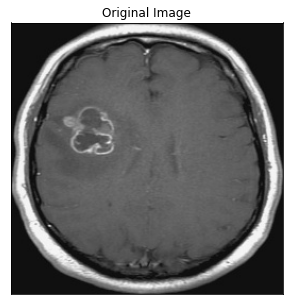

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


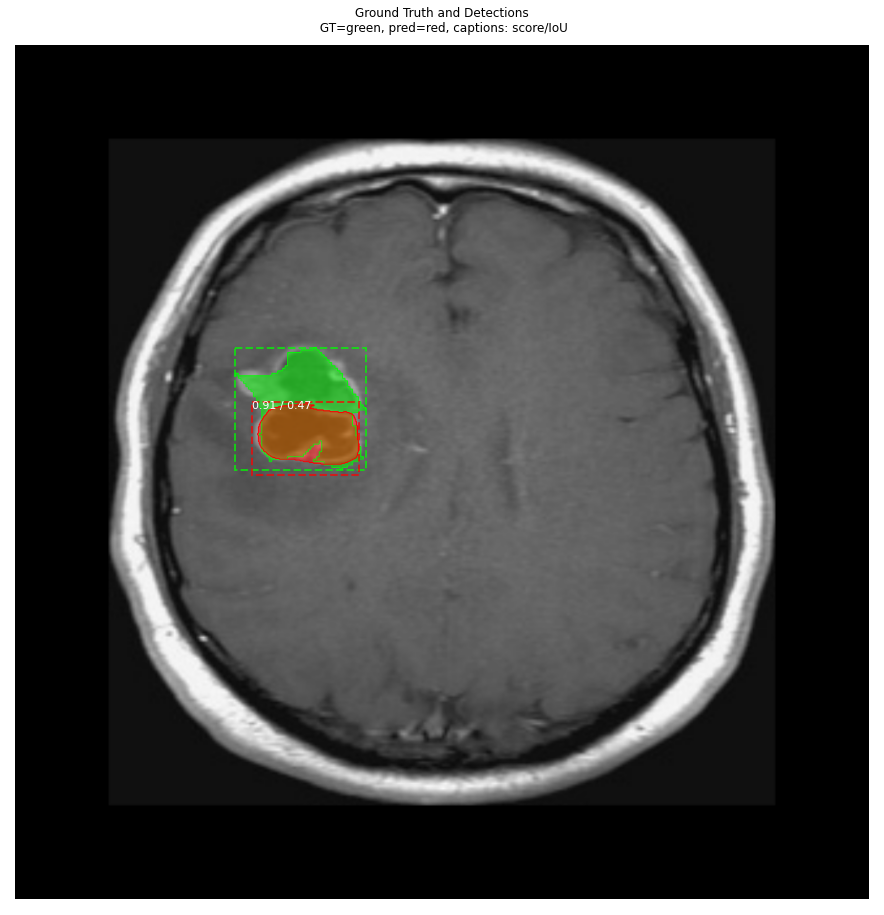

In [ ]:
ind = 2
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

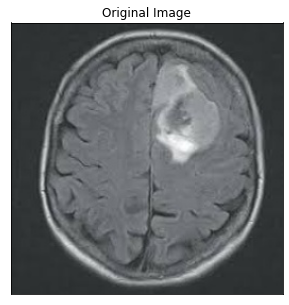

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


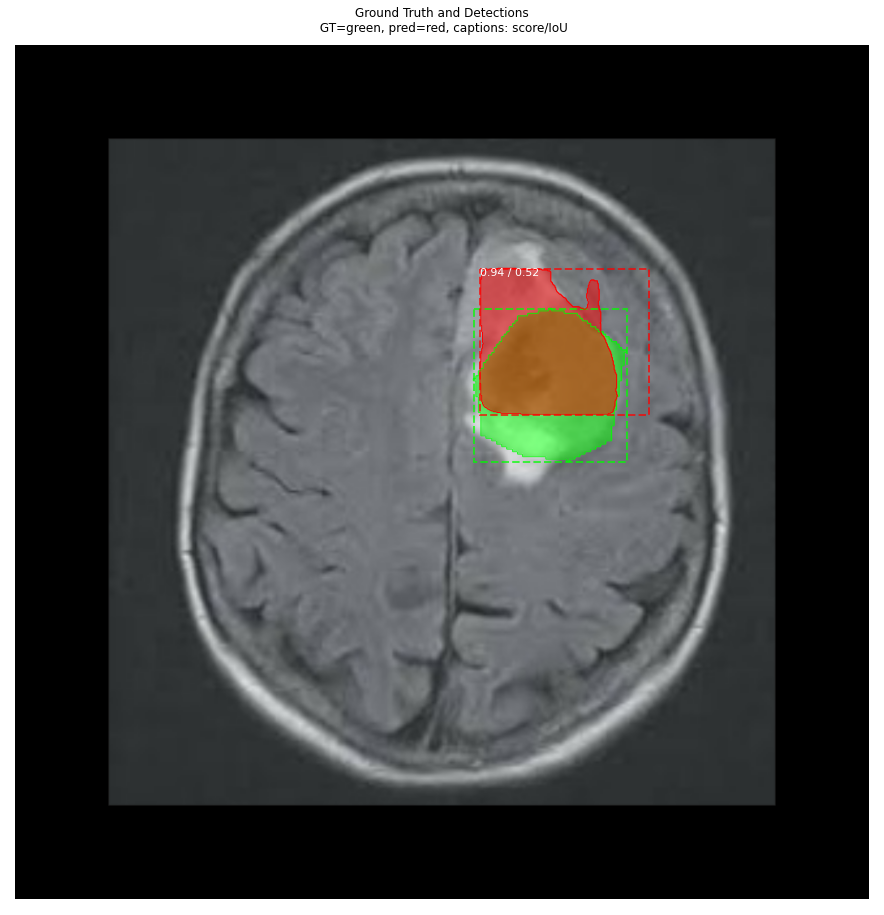

In [ ]:
ind = 14
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

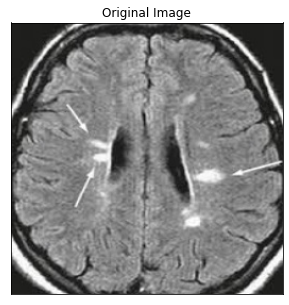

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


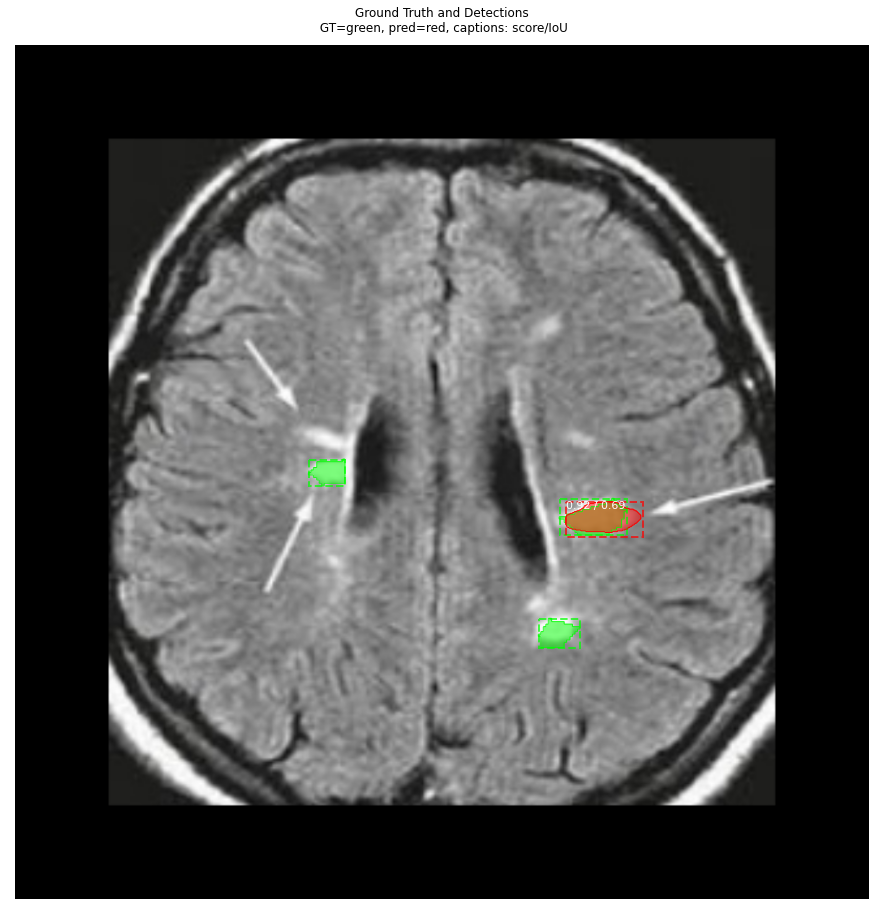

In [ ]:
ind = 9
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

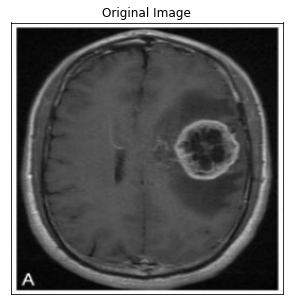

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


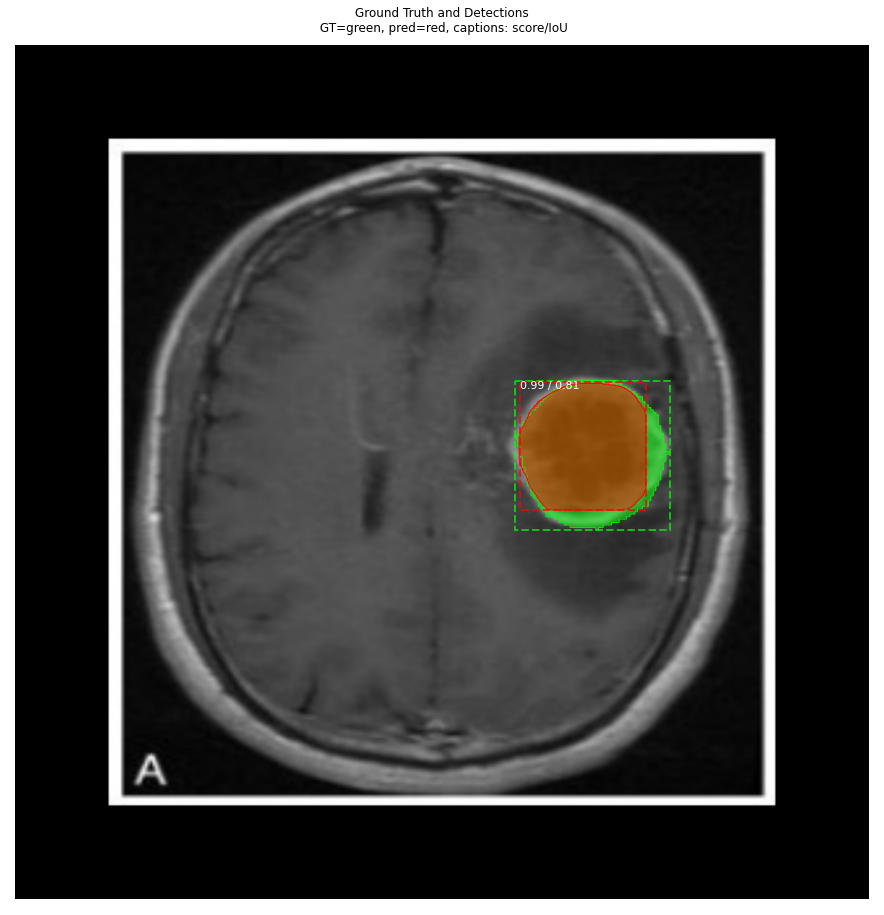

In [ ]:
ind = 0
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

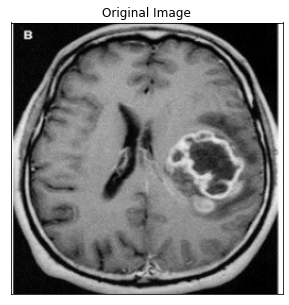

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


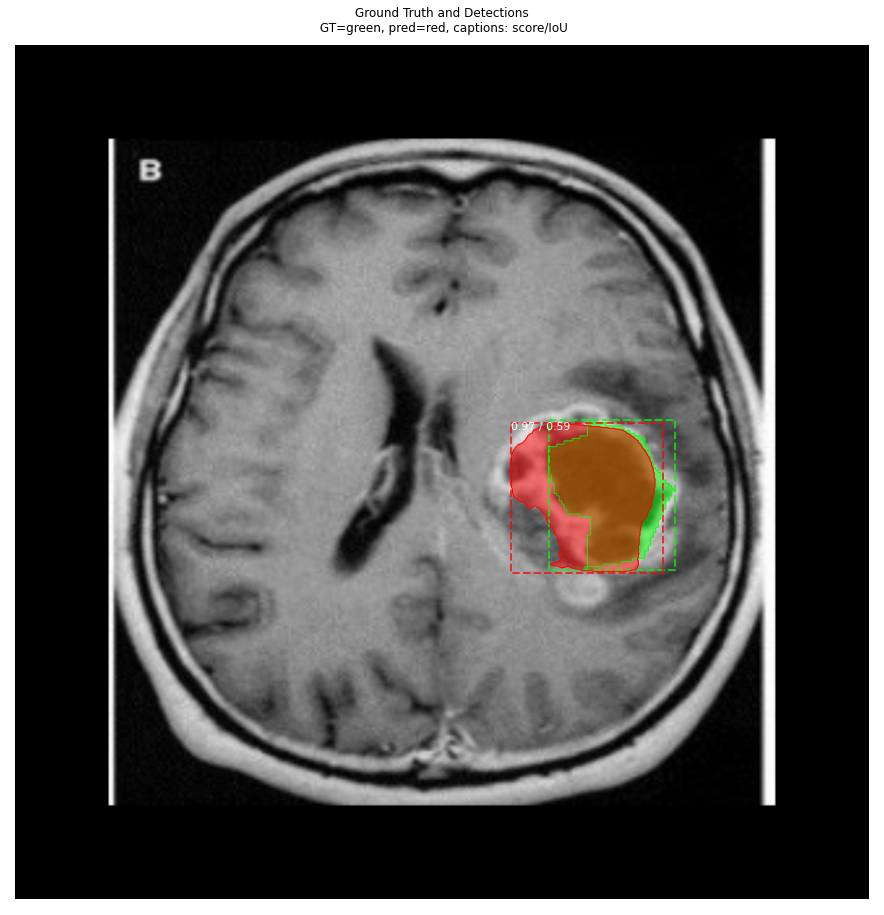

In [ ]:
ind = 1
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

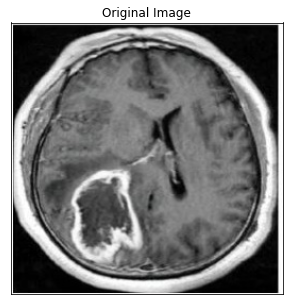

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


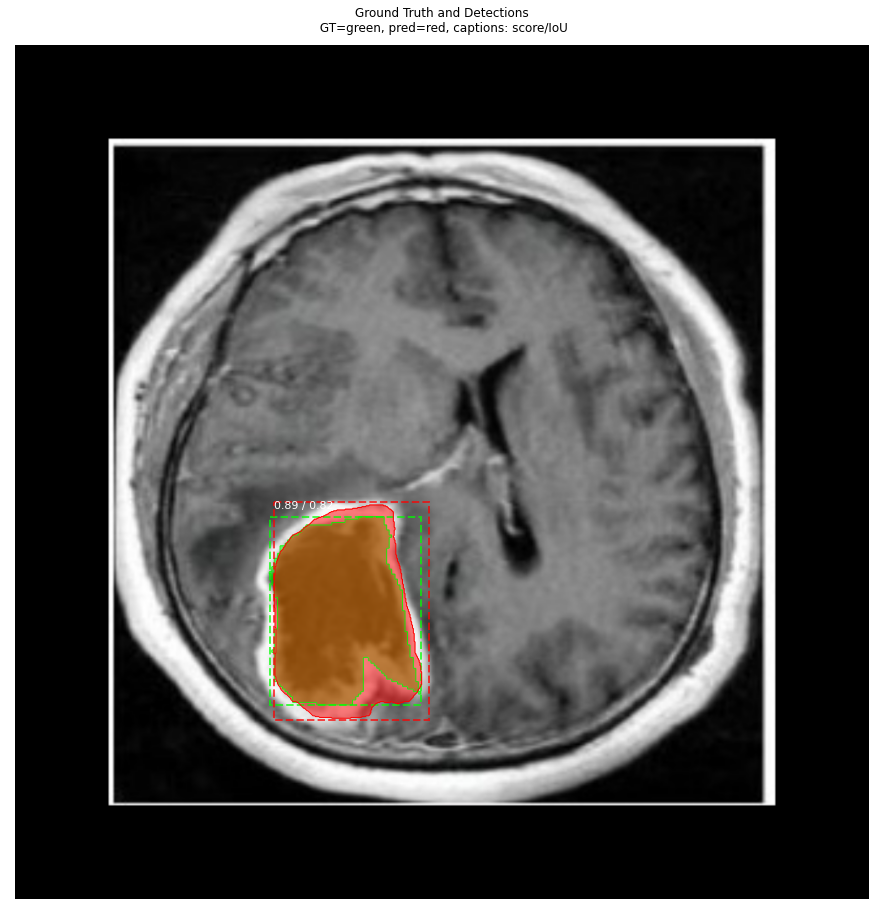

In [ ]:
ind = 2
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

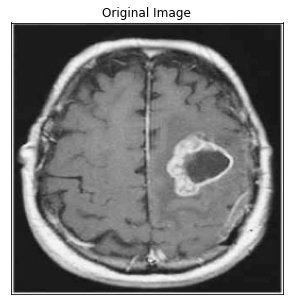

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


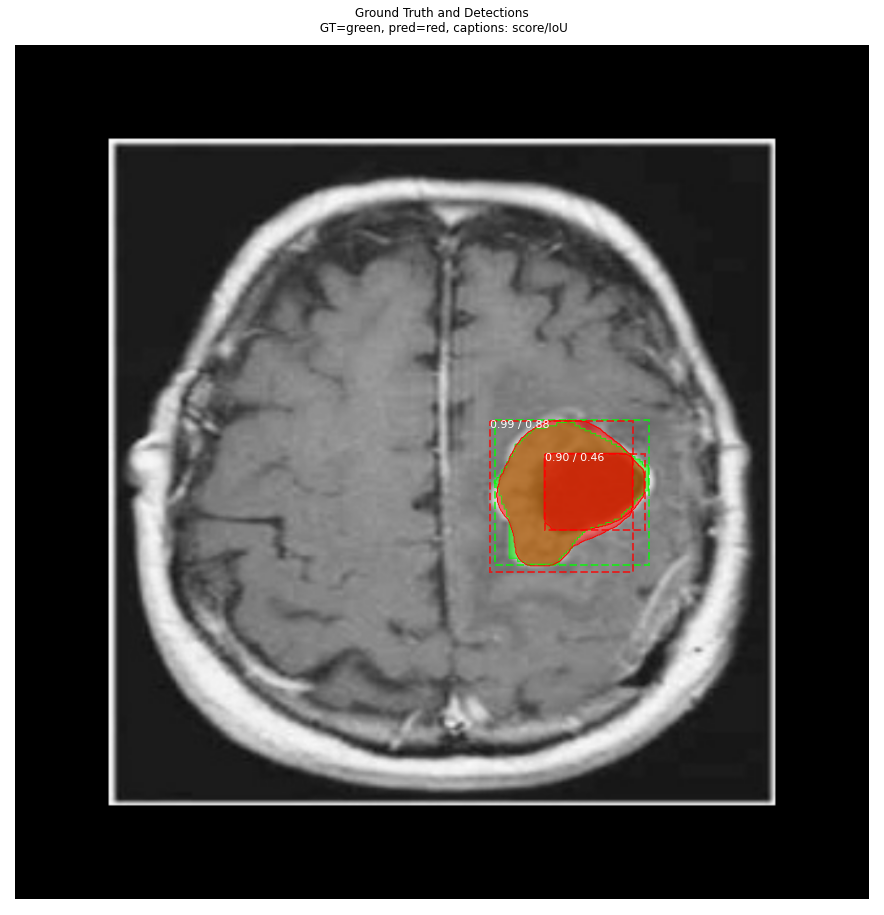

In [ ]:
ind = 3
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

In [ ]:
!rm -rf brain-tumor/
!rm -rf Mask_RCNN/